In [1]:
import pandas as pd
import numpy as np
from Higgs.tools.ImplementationUtils import (
    implementChannelLimit,
    readHEPDataCsv,
    implementChannelWidthLimit,
    fromHB5Table1,
)
import Higgs
from Higgs import predictions as HP
from Higgs import bounds as HB
from Higgs.tools.LimitValidation import validateChannelWidthLimit
import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
import MassResolutions as resolution


# ATLAS 13TeV

## `ggH>ee` finite width [1903.06248](https://arxiv.org/abs/1903.06248)

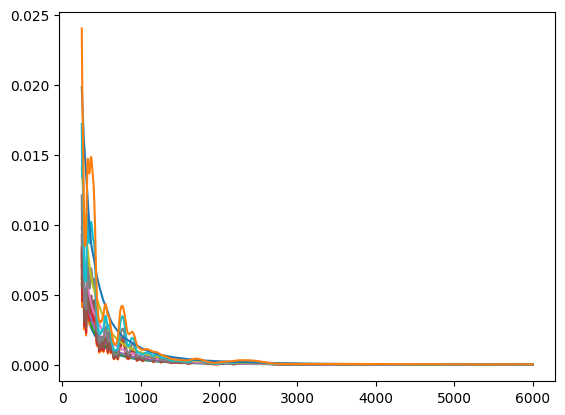

Looks good. Saving this to ggH_LHC13_ATLAS_139.json


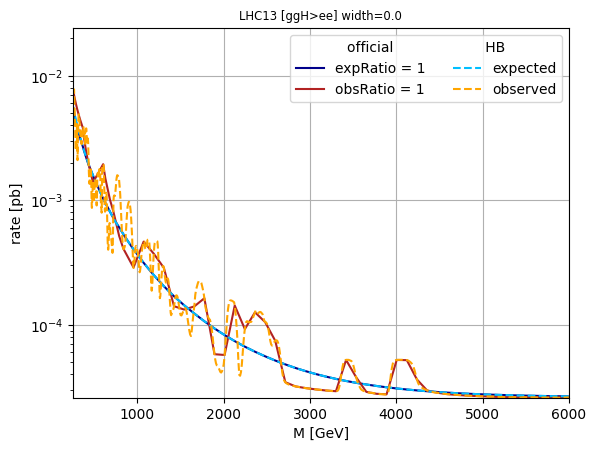

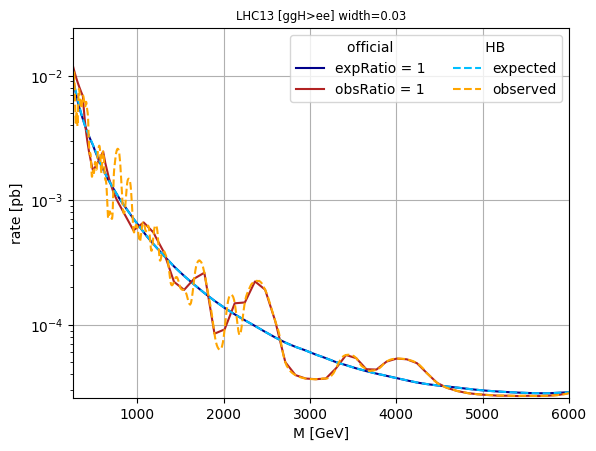

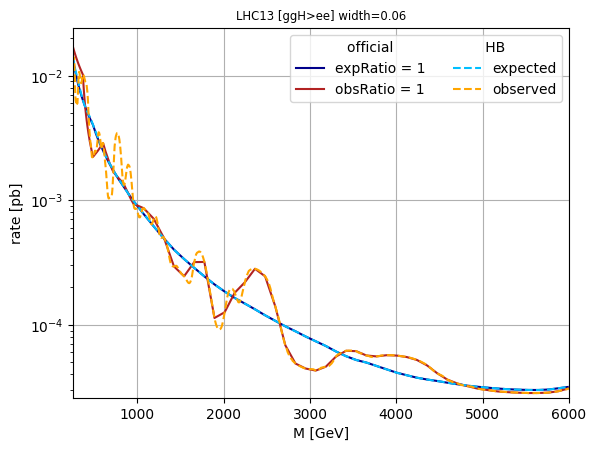

In [2]:
dfsObs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1725190/Observed%20dielectron%20cross-section%20limits/3/csv",
)

for w, df in zip([0, 0.5e-2, 1.2e-2, 3e-2, 6e-2, 10e-2], dfsObs):
    df["normWidth"] = w
df = pd.concat(dfsObs).rename(
    columns={"Mass [GeV]": "m", "Cross section upper limit at 95% CL [fb]": "obs"}
)
df["exp"] = pd.concat(
    readHEPDataCsv(
        "https://www.hepdata.net/download/table/ins1725190/Expected%20dielectron%20cross-section%20limits/3/csv",
    )
)["Cross section upper limit at 95% CL [fb]"]

df.obs *= 1e-3
df.exp *= 1e-3
# spin-0 efficiencies only given for a select few masses
# use the spin-1 efficiencies which are always lower as a conservative estimate for the spin-0 ones
effs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1725190/Selection%20efficiency%20for%20spin-0%2C%20spin-1%20and%20spin-2%20resonances/1/csv",
    na_values=["-"],
)

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

spin1Eff = interp1d(
    *effs[1].to_numpy().T,
    fill_value="extrapolate"  # no significant extrapolation required
)

# since there is only one channel, we put the efficiencies into the limit
df.obs /= spin1Eff(df.m)
df.exp /= spin1Eff(df.m)

limitFile = implementChannelWidthLimit(
    "1903.06248",
    {"channels": [["ggH", "ee"]]},
    "https://doi.org/10.17182/hepdata.88425.v3",
    df,
    idSuffix=1,  # 2 is mumu
    massResolution={"absolute": 1, "relative": 1.5e-2},  # estimate from aux fig 10
)
lim = HB.Limit(limitFile)
validateChannelWidthLimit(lim)


## `h125 > ee` [1909.10235](https://arxiv.org/abs/1909.10235)

In [3]:
df = pd.DataFrame({"m": [125], "obs": [3.6e-4], "exp": [3.5e-4]})
prodModes = ["ggH", "vbfH", "HZ", "HW"]  # b-jet veto
process = {"channels": [[p, "ee"] for p in prodModes]}
limitFile = implementChannelLimit(
    "1909.10235",
    process,
    "p. 7",
    df,
    idSuffix=1,
    prefix="h125",
    massResolution={"relative": 0, "absolute": 6},  # +- 3 GeV
    normalization={
        "reference": "SMHiggsInterp",
        "process": {"channels": [[p, "none"] for p in prodModes]},
    },
    constraints={
        "modelLike": "SMHiggsInterp",
        "process": {"channels": [[p, "none"] for p in prodModes]},
    },
)
lim = HB.Limit(limitFile)
# only one datapoint, so the plot is empty and the automatic validation script
# doesn't do anything
pred = Higgs.Predictions()
h = pred.addParticle(HP.NeutralScalar("h", "even"))
h.setMass(124)
HP.effectiveCouplingInput(
    h,
    HP.smLikeEffCouplings,
    reference="SMHiggsInterp")
h.setBr("bb", 0)  # creates some space in the BRs
h.setBr("ee", df.exp[0])
assert np.isclose(lim.apply(pred)[0].expRatio(), 1)
h.setBr("ee", df.obs[0])
assert np.isclose(lim.apply(pred)[0].obsRatio(), 1)


Looks good. Saving this to h125_LHC13_ATLAS_139.json
